# Cat v Dog CNN

In [1]:
#General
from pathlib import PosixPath
import os
import sys


#Data loading
import numpy as np
from PIL import Image


#Model libraries
import fastai.vision as faiv
import matplotlib.pyplot as plt
from fastai.vision import *
import torchvision
import torch
from torch import nn
from torch.nn.utils import spectral_norm, weight_norm

In [2]:
data_dir = "../../data/dog vs cat"

In [3]:
dev = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on: ", dev)
device = torch.device(dev)

Running on:  cuda


# Data Block API

In [4]:
#class BasicImage(faiv.ItemBase):
#     def __init__(self, path):
#         self.data = open_jpg(path)
        
# class BasicImageList(faiv.ItemList):
#     def __init__(self, items, itemsB=None, **kwargs):
#         super().__init__(items, **kwargs)
#         self.itemsB = itemsB
#         self.copy_new.append('itemsB')
        
#     def get(self, i):
#         path = super().get(i)
#         return BasicImage(path)

In [70]:
from PIL import Image

def open_jpg(path, size):
    i = Image.open(path)
    i2 = i.resize(size)
    a = np.asarray(i2) / 255
    t = torch.Tensor(a)
    t2 = t.permute(2,0,1)
    image = faiv.open_image(path)
    image = image.resize(224)
    return image
    
class MyImageItemList(faiv.ItemList):
    
    def __init__(self, items, itemsB=None, size=(128,128), **kwargs):
        super().__init__(items, **kwargs)
        self.itemsB = itemsB
        self.copy_new.append('itemsB')
        self.size = size
        
    def get(self, i):
        path = super().get(i)
        return open_jpg(path, self.size)
        
    """ custom item list for nifti files """
    def open(self, fn:faiv.PathOrStr)->faiv.Image: return open_jpg(fn)
    

def get_y_label(x):
    name = x.stem
    label = ""
    for c in name:
        if c != '.':
            label += c
        else:
            break
    return label

# Playing with Data 

In [88]:
idb = (MyImageItemList.from_folder(data_dir, extensions=('.jpg'))
                    .split_by_folder()
                    .label_from_folder()
                    .databunch(bs=5))

idb

DataBunch;

Train: LabelList (8000 items)
x: MyImageItemList
Image (3, 375, 499),Image (3, 373, 279),Image (3, 305, 409),Image (3, 464, 500),Image (3, 375, 499)
y: CategoryList
cats,cats,cats,cats,cats
Path: ../../data/dog vs cat;

Valid: LabelList (2000 items)
x: MyImageItemList
Image (3, 474, 499),Image (3, 269, 186),Image (3, 374, 500),Image (3, 260, 214),Image (3, 440, 439)
y: CategoryList
cats,cats,cats,cats,cats
Path: ../../data/dog vs cat;

Test: None

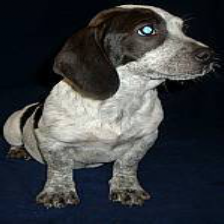

In [89]:
idb.train_ds.x[7030]

# CNN

## Implementing a novel architecture

The following defines the functions which will build the pytorch layers

In [90]:
def conv2d(ni:int, nf:int, ks:int=3, stride:int=2, pad:int=1, norm='batch'):
    bias = not norm == 'batch'
    conv = faiv.init_default(nn.Conv2d(ni,nf,ks,stride,pad,bias=bias))
    conv = spectral_norm(conv) if norm == 'spectral' else weight_norm(conv) if norm == 'weight' else conv
    layers = [conv]
    layers += [nn.ReLU(inplace=True)]  # use inplace due to memory constraints
    layers += [nn.BatchNorm2d(nf)] if norm == 'batch' else []
    return nn.Sequential(*layers)

def res2d_block(ni, nf, ks=3, norm='batch', dense=False):
    """ 2d Resnet block of `nf` features """
    return faiv.SequentialEx(conv2d(ni, nf, ks, pad=ks//2, norm=norm),
                             conv2d(nf, nf, ks, pad=ks//2, norm=norm))


class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

### Assimilating the layers and printing the model.

In [93]:
norm = 'batch'
m1_layers = ([res2d_block(3,16,3,norm=norm)]+
        [conv2d(16,1,ks=1,pad=0,norm=None)]+
        [nn.Flatten()]+
        [nn.Linear(256, 2)])

In [94]:
print(m1_layers)

[SequentialEx(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
), Sequential(
  (0): Conv2d(16, 1, kernel_size=(1, 1), stride=(2, 2))
  (1): ReLU(inplace=True)
), Flatten(), Linear(in_features=256, out_features=2, bias=True)]


In [95]:
novel_model = nn.Sequential(*m1_layers)

## Implementing VGG-19

In [91]:
def block1(ni:int, nf:int, ks:int=3, stride:int=1, pad:int=1, norm=None):
    
    conv = faiv.init_default(nn.Conv2d(ni,nf,ks,stride,pad))
    conv2 = nn.Conv2d(ni,nf,ks,stride,pad)
    
    layers += [conv]
    layers += [conv2]
    layers += [nn.AvgPool2d(ks, stride=2, padding=1)]
    
    return nn.Sequential(*layers)

def block2(ni:int, nf:int, ks:int=3, stride:int=1, pad:int=1, norm=None):
    
    conv = faiv.init_default(nn.Conv2d(ni,nf,ks,stride,pad))
    conv2 = nn.Conv2d(ni,nf,ks,stride,pad)
    conv3 = nn.Conv2d(ni,nf,ks,stride,pad)
    conv4 = nn.Conv2d(ni,nf,ks,stride,pad)
    
    layers += [conv]
    layers += [conv2]
    layers += [conv3]
    layers += [conv4]
    
    layers += [nn.AvgPool2d(ks, stride=2, padding=1)]
    
    return nn.Sequential(*layers)


# Training

In [84]:
data_dir = PosixPath('../../data/dog vs cat')
data_dir.ls()

[PosixPath('../../data/dog vs cat/valid'),
 PosixPath('../../data/dog vs cat/train')]

In [85]:
loss = nn.CrossEntropyLoss()
learner = faiv.Learner(idb, model_novel, loss_func=loss)

## Training a novel architecture

In [92]:
learner.novel_model

AttributeError: 'Learner' object has no attribute 'novel_model'

In [64]:
learner.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 64, 64]         432        True      
______________________________________________________________________
ReLU                 [16, 64, 64]         0          False     
______________________________________________________________________
BatchNorm2d          [16, 64, 64]         32         True      
______________________________________________________________________
Conv2d               [16, 32, 32]         2,304      True      
______________________________________________________________________
ReLU                 [16, 32, 32]         0          False     
______________________________________________________________________
BatchNorm2d          [16, 32, 32]         32         True      
______________________________________________________________________
Conv2d               [1, 16, 16]          17         True      
___________________________________________________

In [66]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,time
0,0.692862,0.690622,00:17
1,0.679680,0.670252,00:11
2,0.649674,0.663211,00:11
3,0.629630,0.657216,00:11


In [69]:
models.resnet50??